In [2]:
# unzip data
!unzip motion_data.zip

Archive:  motion_data.zip
   creating: motion_data/
   creating: motion_data/move_twist/
  inflating: motion_data/move_twist/move_twist_1750391662.npy  
  inflating: motion_data/move_twist/move_twist_1750391615.npy  
  inflating: motion_data/move_twist/move_twist_1750391441.npy  
  inflating: motion_data/move_twist/move_twist_1750391543.npy  
  inflating: motion_data/move_twist/move_twist_1750391398.npy  
  inflating: motion_data/move_twist/move_twist_1750391566.npy  
  inflating: motion_data/move_twist/move_twist_1750391549.npy  
  inflating: motion_data/move_twist/move_twist_1750391620.npy  
  inflating: motion_data/move_twist/move_twist_1750391538.npy  
  inflating: motion_data/move_twist/move_twist_1750391484.npy  
  inflating: motion_data/move_twist/move_twist_1750391599.npy  
  inflating: motion_data/move_twist/move_twist_1750391709.npy  
  inflating: motion_data/move_twist/move_twist_1750391490.npy  
  inflating: motion_data/move_twist/move_twist_1750391457.npy  
  inflating: mo

In [3]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Map labels to integers
label_map = {"move_none": 0, "move_circle": 1, "move_shake": 2, "move_twist": 3}

data = []
labels = []
expected_length = 300  # fixed length for each sample after flattening

# Load data from folders
for label_name in os.listdir("motion_data"):
    label_path = os.path.join("motion_data", label_name)

    # Skip if not a directory (e.g., skip files like .DS_Store)
    if not os.path.isdir(label_path):
        continue

    for file in os.listdir(label_path):
        if file.endswith(".npy"):
            file_path = os.path.join(label_path, file)
            sample = np.load(file_path)
            sample = sample.flatten()

            # Pad or truncate to fixed length
            if sample.shape[0] < expected_length:
                sample = np.pad(sample, (0, expected_length - sample.shape[0]), mode='constant')
            elif sample.shape[0] > expected_length:
                sample = sample[:expected_length]

            data.append(sample)
            labels.append(label_map[label_name])

# Convert lists to arrays
X = np.array(data)
y = tf.keras.utils.to_categorical(labels, num_classes=4)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)
print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)


Data shape: (241, 300)
Labels shape: (241, 4)
Train shape: (192, 300) (192, 4)
Validation shape: (49, 300) (49, 4)


In [4]:
# Fully connected model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(300,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [5]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=1, epochs=15)

Epoch 1/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5448 - loss: 1.1701 - val_accuracy: 0.9592 - val_loss: 0.2615
Epoch 2/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9532 - loss: 0.1970 - val_accuracy: 0.9796 - val_loss: 0.1254
Epoch 3/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0462 - val_accuracy: 1.0000 - val_loss: 0.0378
Epoch 4/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 1.0000 - val_loss: 0.0300
Epoch 5/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0266
Epoch 6/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0201
Epoch 7/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.0254
Epoch 8/15
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.

In [6]:
# Convert Model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("motion_model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpecxr8bm6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136133509185360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136133509184208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136133506646864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136133506648016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136133509181328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136133506646480: TensorSpec(shape=(), dtype=tf.resource, name=None)


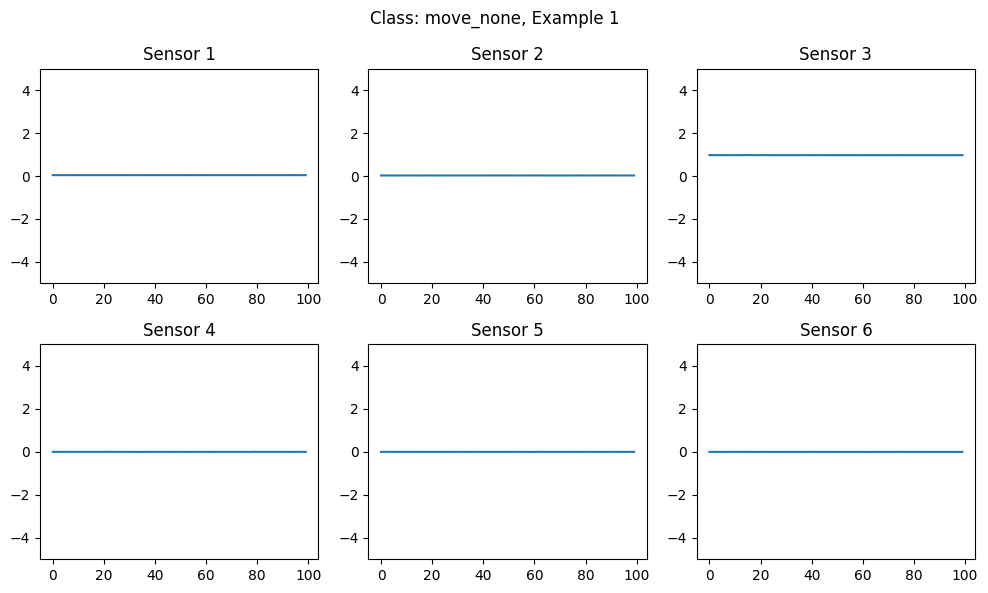

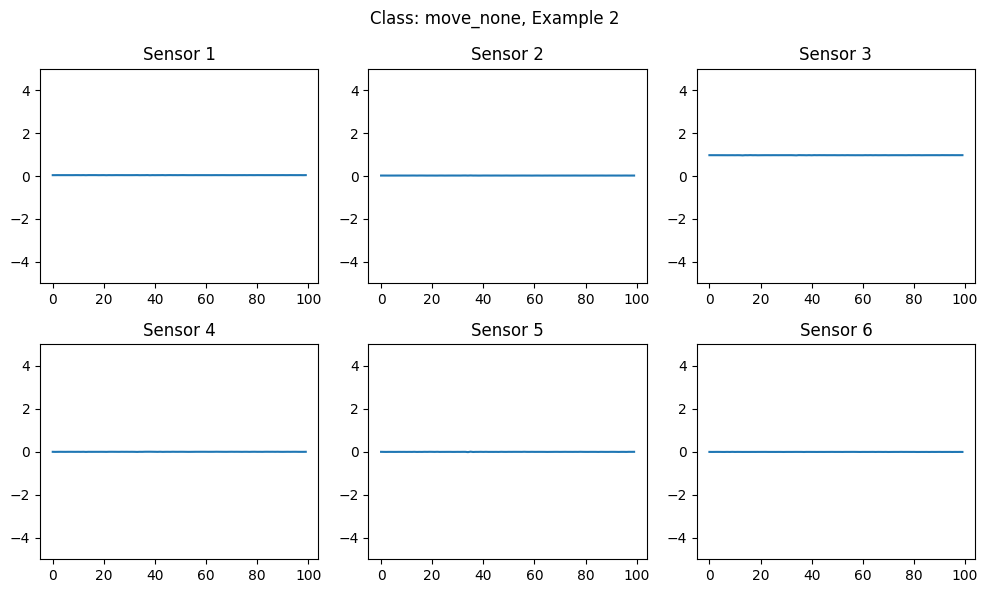

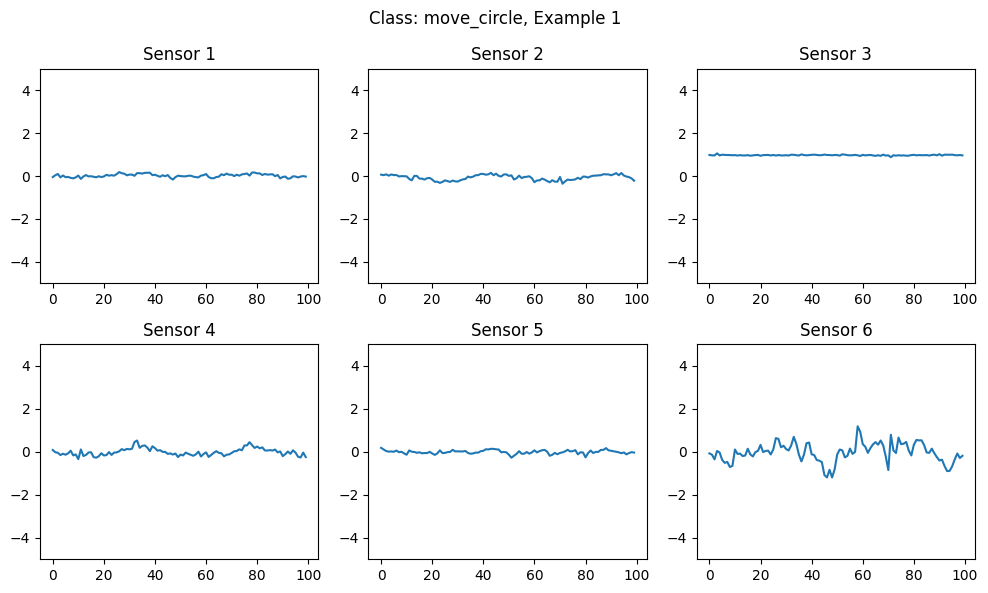

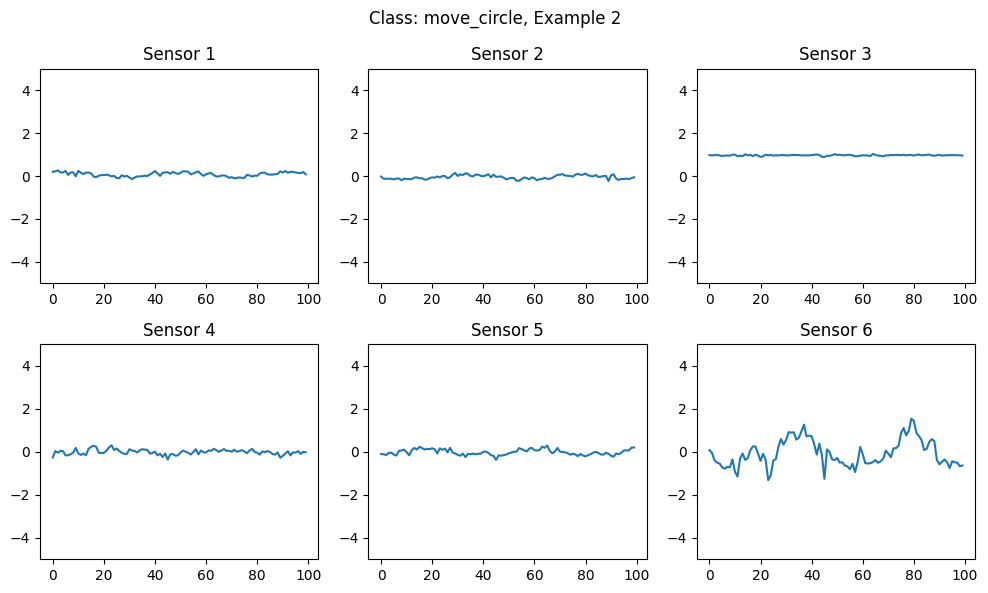

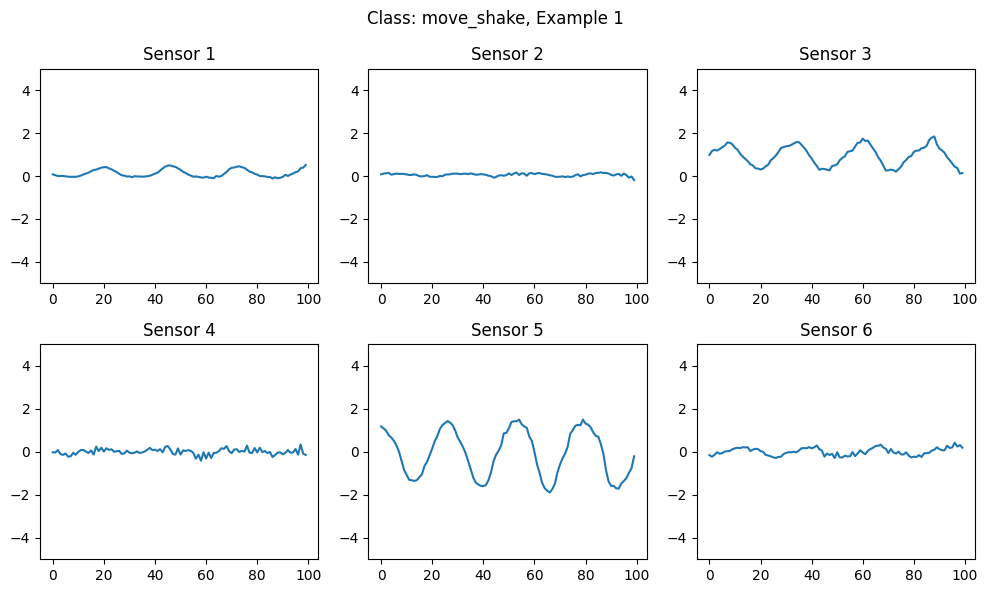

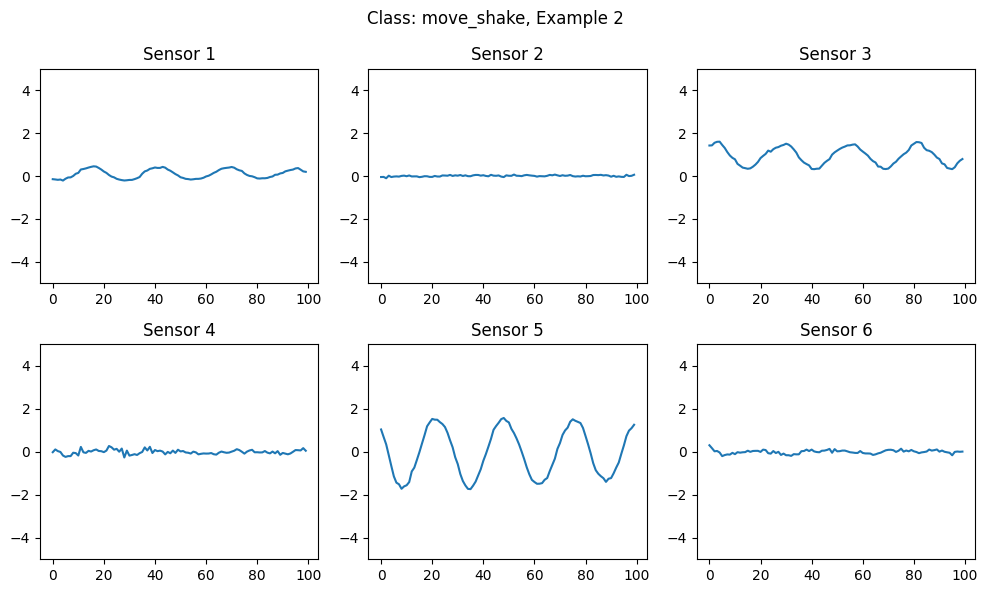

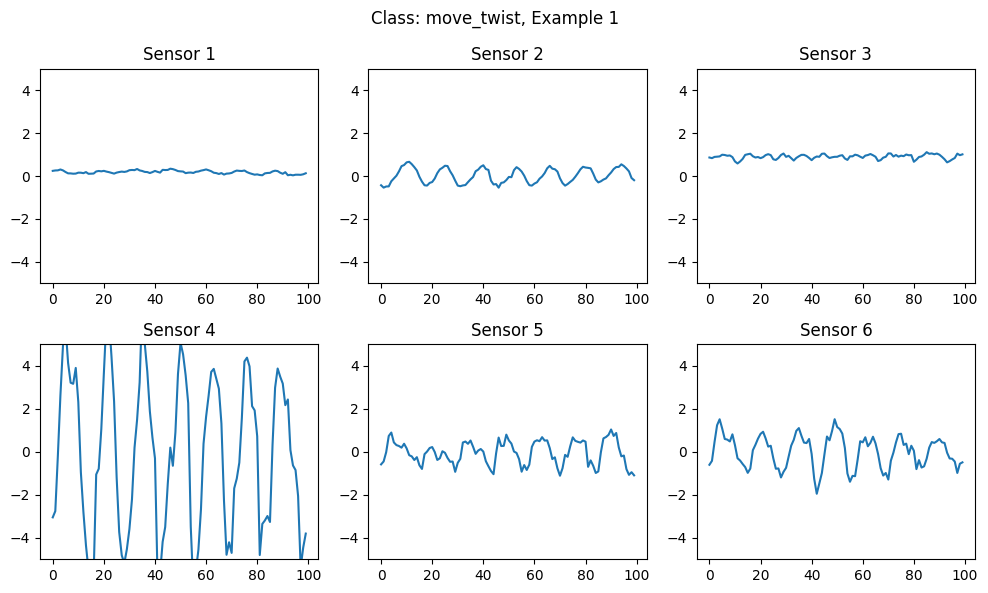

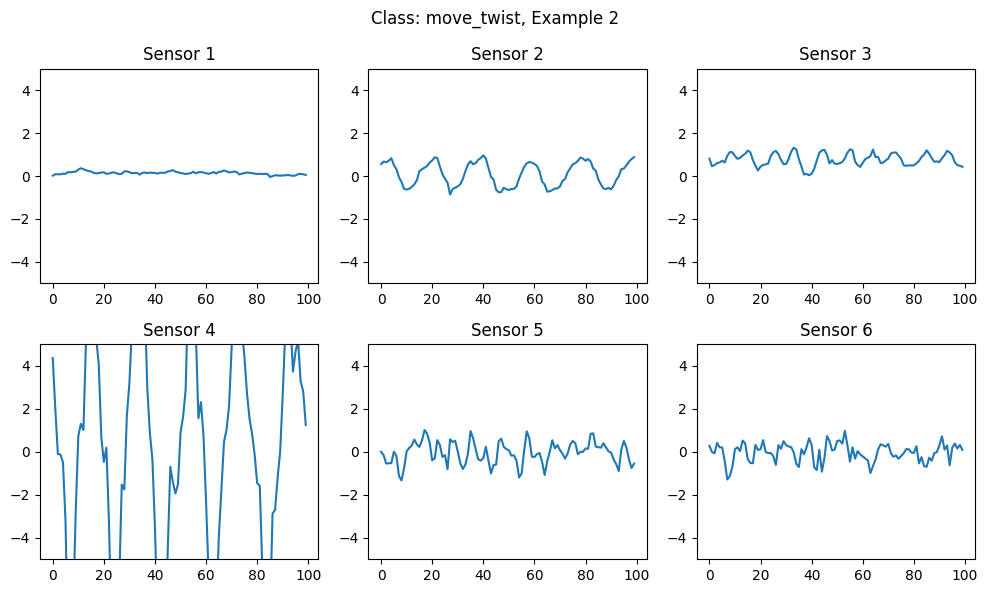

In [7]:
import matplotlib.pyplot as plt

num_examples_per_class = 2  # Number of examples to plot per class
y_min = -5
y_max = 5

label_map_inv = {0: "move_none", 1: "move_circle", 2: "move_shake", 3: "move_twist"}

for label in range(4):
    class_files = [f for f in os.listdir(f"motion_data/{label_map_inv[label]}") if f.endswith(".npy")]
    for i in range(min(num_examples_per_class, len(class_files))):
        file_path = f"motion_data/{label_map_inv[label]}/{class_files[i]}"
        sample = np.load(file_path)

        plt.figure(figsize=(10, 6))
        for j in range(6):
            plt.subplot(2, 3, j + 1)
            plt.plot(sample[:, j])
            plt.ylim(y_min, y_max)  # Set y-axis limits
            plt.title(f"Sensor {j+1}")
        plt.suptitle(f"Class: {label_map_inv[label]}, Example {i+1}")
        plt.tight_layout()
        plt.show()
